In [1]:
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F

from functools import partial
import matplotlib.pyplot as plt

from toss.utils import flatten
from toss.layers import Lambda, GeneralReLU
from toss.train import Trainer
from toss.data import get_mnist, get_gens, DataSet, DataBunch, normalize
from toss.utils import listify
from toss.optimizers import Optimizer
from toss.metrics import accuracy
from toss.callbacks import AvgStatsCallback, Recorder, BatchTransformCallback
from toss.callbacks import CudaCallback
from toss.containers import ListContainer
from toss.hooks import Hook, Hooks, plot_hooks_act, plot_hooks_min_act

In [2]:
x_train, y_train, x_valid, y_valid = get_mnist()
x_train, x_valid = normalize(x_train, x_valid)

train_ds = DataSet(x_train, y_train)
valid_ds = DataSet(x_valid, y_valid)

n_obj, n_feats = x_train.shape
n_classes = y_train.max() + 1
batch_size = 512

data = DataBunch(*get_gens(train_ds, valid_ds, batch_size), n_classes)

In [3]:
def view_tfm(*size):
    def _inner(x):
        return x.view(*((-1,) + size))
    return _inner

def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn), GeneralReLU(**kwargs)
    ]
    if bn:
        layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

def get_cnn_layers(data, layer, nfs, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i == 0 else 3, **kwargs)
            for i in range(len(nfs) - 1)
           ] + [nn.AdaptiveAvgPool2d(1),Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def init_cnn(model):
    def _init_cnn(layer, func):
        if isinstance(layer, nn.Conv2d):
            f(layer.weight, a=0.1)
            if getattr(layer, "bias", None) is not None:
                layer.bias.data.zero_()
        for l in layer.children():
            _init_cnn(l, func)
            
    f = torch.nn.init.kaiming_normal_
    _init_cnn(model, f)
    return model

In [4]:
def get_cnn_model(data, layer, nfs, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, layer, nfs, **kwargs))

In [116]:
def get_trainer(data, nfs, layer, lr=0.6, cbs=None,opt=None, **kwargs):
    model = get_cnn_model(data, layer, nfs, **kwargs)
    if opt is None:
        opt = Optimizer(model.parameters(), lr=lr)
    trainer = Trainer(model, data, F.cross_entropy, opt, cbs=cbs)
    return trainer, model

In [7]:
nfs = [8, 16, 32, 64, 64]
metrics = [accuracy]
cbs = [AvgStatsCallback(metrics),
        Recorder(),
       CudaCallback(),
        partial(BatchTransformCallback, view_tfm(1,28,28))
       ]

In [8]:
def append_stats(hook, mod, inp, out):
    if not hasattr(hook, "stats"):
        hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(out.data.mean())
    stds.append(out.data.std())
    hists.append(out.data.cpu().histc(40, -7, 7))

In [110]:
trainer, model = get_trainer(data, nfs, ConvLayer, lr=0.9,
                             leak=0., sub=0., upper_bound=6.0, cbs=cbs)

Epoch: 1
	train : [0.2578416015625, tensor(0.9191, device='cuda:0')]
	valid : [0.1450889892578125, tensor(0.9539, device='cuda:0')]
Epoch: 2
	train : [0.0601593017578125, tensor(0.9811, device='cuda:0')]
	valid : [0.05907808837890625, tensor(0.9830, device='cuda:0')]
Epoch: 3
	train : [0.03998819091796875, tensor(0.9876, device='cuda:0')]
	valid : [0.05949358520507812, tensor(0.9820, device='cuda:0')]
Epoch: 4
	train : [0.0291834228515625, tensor(0.9908, device='cuda:0')]
	valid : [0.06271959838867187, tensor(0.9802, device='cuda:0')]
Epoch: 5
	train : [0.0223949169921875, tensor(0.9931, device='cuda:0')]
	valid : [0.052073095703125, tensor(0.9850, device='cuda:0')]
Epoch: 6
	train : [0.01624862060546875, tensor(0.9955, device='cuda:0')]
	valid : [0.05879906005859375, tensor(0.9836, device='cuda:0')]
Epoch: 7
	train : [0.015332974853515625, tensor(0.9953, device='cuda:0')]
	valid : [0.056199993896484376, tensor(0.9836, device='cuda:0')]
Epoch: 8
	train : [0.0123341259765625, tensor(0.9

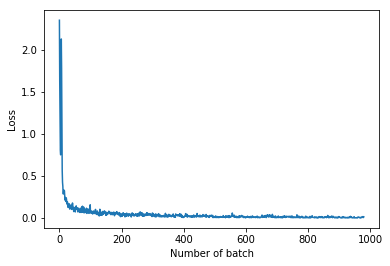

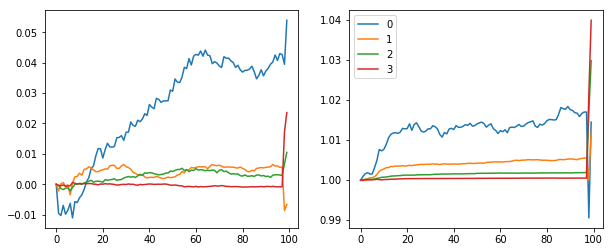

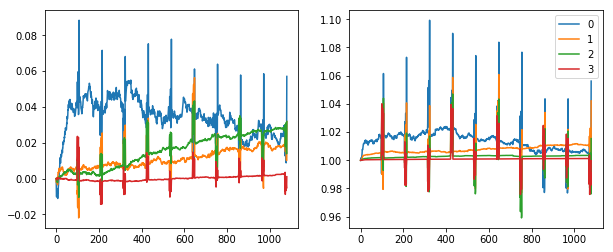

In [113]:
with Hooks(model, append_stats) as hooks:
    trainer.fit(6)
    plot_hooks(hooks[:4], 100)
    plot_hooks(hooks[:4])